# Problem 1.2

In [87]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

In [88]:
# load data
batch_size = 128
train_set, test_set, train_loader, test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)


device = 'cpu'

In [89]:
# set up model architecture
class RestrBoltzMachiNet(nn.Module):
    """Restricted Boltzmann Machine for generating MNIST images."""
    
    def __init__(self, D: int, F: int, k: int):        
        super(RestrBoltzMachiNet, self).__init__()
        self.m = F
        self.W = nn.Parameter(torch.randn(F, D)* 1e-2) # Initialized from Normal(mean=0.0, variance=1e-4)
        self.c = nn.Parameter(torch.zeros(D)) # Initialized as 0.0
        self.b = nn.Parameter(torch.zeros(F)) # Initilaized as 0.0
        self.k = k
    
    
    def sample_x(self, mu, sigma):
        """Sample from a normal distribution defined by a given parameter.
        
           Args:
                mu: Mean of the normal distribution.
                sigma: Standard deviation of the normal distribution.
           
           Returns:
               bern_sample: Sample from Bernoulli(p)
        """
        
        norm_sample = torch.normal(mu, sigma)
        return norm_sample
    
    def sample_h(self, p):
        """Sample from a bernoulli distribution defined by a given parameter.
        
           Args:
                p: Parameter of the bernoulli distribution.
           
           Returns:
               bern_sample: Sample from Bernoulli(p)
        """
        
        bern_sample = p.bernoulli()
        return bern_sample
    
    
    def P_h_x(self, x):
        """Returns the conditional P(h|x). (Slide 9, Lecture 14)
        
        Args:
            x: The parameter of the conditional h|x.
        
        Returns:
            ph_x: probability of hidden vector being element-wise 1.
        """

        ph_x = torch.sigmoid(F.linear(x, self.W, self.b)) # n_batch x F
        return ph_x
    
    
    def P_x_h(self, h):
        """Returns the conditional P(x|h). (Slide 9, Lecture 14)
        
        Args:
            h: The parameter of the conditional x|h.
        
        Returns:
            px_h: probability of visible vector being element-wise 1.
        """
        
        px_h_mu = torch.sigmoid(F.linear(h, self.W.t(), self.c)) # n_batch x D
        px_h_sigma = torch.sigmoid(F.linear(h, self.W.t(), self.c)) # n_batch x D
        return px_h_mu, px_h_sigma

    
    def free_energy(self, x):
        """Returns the Average F(x) free energy. (Slide 11, Lecture 14)."""
        
        vbias_term = x.mv(self.c) # n_batch x 1
        wv_b = F.linear(x, self.W, self.b) # n_batch x F
        hidden_term = F.softplus(wv_b).sum(dim=1) # n_batch x 1
        return (-hidden_term - vbias_term).mean() # 1 x 1 
    
    
    def forward(self, x):
        """Generates x_negative using MCMC Gibbs sampling starting from x."""
        
        x_negative = x
        for _ in range(self.k):
            
            ## Step 1: Sample h from previous iteration.
            # Get the conditional prob h|x
            phx_k = self.P_h_x(x_negative) 
            # Sample from h|x
            h_negative = self.sample_h(phx_k)
            
            ## Step 2: Sample x using h from step 1.
            # Get the conditional proba x|h
            pxh_k_mu, pxh_k_sigma = self.P_x_h(h_negative)
            # Sample from x|h
            x_negative = self.sample_x(pxh_k_mu, pxh_k_sigma)

        return x_negative, pxh_k_mu, pxh_k_sigma

In [99]:
# build training loop
def train(model, device, train_loader, optimizer, epoch):
    
    train_loss = 0
    model.train()
    m = model.m
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # torchvision provides us with normalized data, s.t. input is in [0,1]
        data = data.view(data.size(0),-1) # flatten the array: Converts n_batchx1x28x28 to n_batchx784
        data = data.bernoulli() 
        data = data.to(device)
        
        optimizer.zero_grad()
        
        x_tilde, _, _ = model(data)
        x_tilde = x_tilde.detach()
        
        loss = model.free_energy(data) - model.free_energy(x_tilde)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if (batch_idx+1) % (len(train_loader)//4) == 0:
            print(f"M={m}; Epoch={epoch}, {round(100. * batch_idx / len(train_loader))}% complete", end="\r")
    print("\n")

def test(model, device, test_loader):
    
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            data = data.bernoulli()
            data = data.to(device)
            xh_k,_,_ = model(data)
            loss = criterion(data, xh_k)
            test_loss += loss.item() # sum up batch loss
    
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print(f"M={model.m}; Test MSE = {test_loss}")
    
# set up optimizer/scheduler
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs.get('momentum', 0.), 
                              weight_decay=kwargs.get('weight_decay', 0.))
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [100]:
# training setup

optimizer_name = 'Adam'
scheduler_name = 'MultiStepLR'
num_epochs = 25
lr = 0.001

In [101]:
# run training
device = torch.device(device)

rbms = [RestrBoltzMachiNet(D=28*28, F=10, k=10).to(device),
       RestrBoltzMachiNet(D=28*28, F=50, k=10).to(device),
       RestrBoltzMachiNet(D=28*28, F=100, k=10).to(device),
       RestrBoltzMachiNet(D=28*28, F=250, k=10).to(device)]

i = 0
for rbm in rbms:
    optimizer = make_optimizer(optimizer_name, rbm, lr=lr)
    scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)

    print("Beginning training...")
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch} of {num_epochs}")
        train(rbm, device, train_loader, optimizer, epoch)
        scheduler.step()
    
    rbms[i] = rbm
    i += 1

Beginning training...
Epoch 1 of 25
M=10; Epoch=1, 100% complete

Epoch 2 of 25
M=10; Epoch=2, 100% complete

Epoch 3 of 25
M=10; Epoch=3, 100% complete

Epoch 4 of 25
M=10; Epoch=4, 100% complete

Epoch 5 of 25
M=10; Epoch=5, 100% complete

Epoch 6 of 25
M=10; Epoch=6, 100% complete

Epoch 7 of 25
M=10; Epoch=7, 100% complete

Epoch 8 of 25
M=10; Epoch=8, 100% complete

Epoch 9 of 25
M=10; Epoch=9, 100% complete

Epoch 10 of 25
M=10; Epoch=10, 100% complete

Epoch 11 of 25
M=10; Epoch=11, 100% complete

Epoch 12 of 25
M=10; Epoch=12, 100% complete

Epoch 13 of 25
M=10; Epoch=13, 100% complete

Epoch 14 of 25
M=10; Epoch=14, 100% complete

Epoch 15 of 25
M=10; Epoch=15, 100% complete

Epoch 16 of 25
M=10; Epoch=16, 100% complete

Epoch 17 of 25
M=10; Epoch=17, 100% complete

Epoch 18 of 25
M=10; Epoch=18, 100% complete

Epoch 19 of 25
M=10; Epoch=19, 100% complete

Epoch 20 of 25
M=10; Epoch=20, 100% complete

Epoch 21 of 25
M=10; Epoch=21, 100% complete

Epoch 22 of 25
M=10; Epoch=22,

In [102]:
for rbm in rbms:
    test(rbm, device, test_loader)

M=10; Test MSE = 0.2886427856445313
M=50; Test MSE = 0.29383039016723633
M=100; Test MSE = 0.29727467880249026
M=250; Test MSE = 0.3012441173553467


# Problem 2.1

In [172]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import os
from tsne import *

In [159]:
# labels for later
master_labels = ["T-shirt", "Pants", "Pullover" , "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# prepare data loaders
batch_size = 128

train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)
train_set, val_set = random_split(train_set, [int(0.8 * len(train_set)), len(train_set) - int(0.8 * len(train_set))])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [160]:
class ConditioNet(nn.Module):
    def __init__(self, n_class, n_in, n_hid, z_dim):
        super(ConditioNet, self).__init__()

        self.enc1 = nn.Linear(n_in + n_class, n_hid)
        self.enc2m = nn.Linear(n_hid, z_dim)
        self.enc2s = nn.Linear(n_hid, z_dim)
        self.dec1 = nn.Linear(z_dim, n_hid)
        self.dec2 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        h1 = F.relu(self.enc1(x))
        return self.enc2m(h1), self.enc2s(h1)

    def reparameterize(self, mu, logvar):        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z):
        h3 = F.relu(self.dec1(z))
        return torch.sigmoid(self.dec2(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [161]:
def loss_function(recon_x, x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

In [162]:
def train_cVAE(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
        target_onehot = torch.zeros(data.shape[0], 10)
        target_onehot[range(data.shape[0]), target] = 1
        data_adj = torch.cat((data, target_onehot), dim=1)
        
        data = data.to(device)
        data_adj = data_adj.to(device)
        
        optimizer.zero_grad()
        output, mu, logvar = model(data_adj)
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return train_loss

def test_cVAE(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)
            target_onehot = torch.zeros(data.shape[0], 10)
            target_onehot[range(data.shape[0]), target] = 1
            data_adj = torch.cat((data, target_onehot), dim=1)
            
            data = data.to(device)
            data_adj = data_adj.to(device)
            
            output, mu, logvar = model(data_adj)
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))
    return test_loss

def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer

In [ ]:
# set up model training

optimizer_name = 'Adam'

val_num_epochs = 10
train_num_epochs = 10
n_class = 10
n_in = 28*28
n_hids = list(range(100, 801, 200))
z_dims = list(range(5, 51, 25))
lrs = list(range(-4, 0, 1))

device = torch.device(device)


# if present, load tested hyperparameters
if os.path.exists("hyperparameters.pth"):
    hyperparams = torch.load("hyperparameters.pth")
else:
    hyperparams = torch.empty(0,4)
    

# grid search for best n_hid, z_dim
i = 0
for n_hid in n_hids:
    for z_dim in z_dims:
        for lr_init in lrs:

            # skip iteration if already done
            i += 1
            row_match = (hyperparams[:, 0] == n_hid) & (hyperparams[:, 1] == z_dim) & (hyperparams[:, 2] == lr_init)
            if torch.any(row_match):
                continue
                
            # set up model
            lr = 10**lr_init
            cvae = ConditioNet(n_class, n_in, n_hid, z_dim).to(device)
            optimizer = make_optimizer(optimizer_name, cvae, lr=lr)

            # train model
            print(f'Combination {i} of {len(n_hids) * len(z_dims) * len(lrs)}: n_hid = {n_hid}, z_dim = {z_dim}, lr = {10**lr_init}')
            
            cvae.train()
            for epoch in range(1, val_num_epochs + 1):
                train_cVAE(cvae, device, train_loader, optimizer, epoch)

            # generate validation loss
            cvae.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    data = data.view(data.size(0),-1)
                    target_onehot = torch.zeros(data.shape[0], 10)
                    target_onehot[range(data.shape[0]), target] = 1
                    data_adj = torch.cat((data, target_onehot), dim=1)

                    data = data.to(device)
                    data_adj = data_adj.to(device)

                    output, mu, logvar = cvae(data_adj)
                    loss = loss_function(output, data, mu, logvar)
                    val_loss += loss.item() # sum up batch loss
            val_loss = (val_loss*batch_size)/len(val_loader.dataset)

            # save model, if best
            if not os.path.exists("best_cVAE_weights.pth"):
                torch.save(cvae.state_dict(), "best_cVAE_weights.pth")
            elif val_loss < torch.min(hyperparams[:,3]):
                torch.save(cvae.state_dict(), "best_cVAE_weights.pth")
            
            # store model, validation loss, hyperparameters
            # save hyperparameters
            cur_hyperparams = torch.Tensor([n_hid, z_dim, lr_init, val_loss]).unsqueeze(0)
            hyperparams = torch.cat((hyperparams, cur_hyperparams))
            torch.save(hyperparams, "hyperparameters.pth")

print("Search complete!")

In [239]:
# load best model
hyperparams = torch.load("hyperparameters.pth")
best_ind = torch.argmin(hyperparams[:,3])
n_hid_best, z_dim_best, lr_best = [float(elem) for elem in hyperparams[best_ind, :3]]
print(f'Best parameters: n_hid = {n_hid_best}, z_dim = {z_dim_best}, lr = {10**lr_best}')

best_cvae = ConditioNet(int(n_class), int(n_in), int(n_hid_best), int(z_dim_best))
best_cvae.load_state_dict(torch.load("best_cVAE_weights.pth"))

Best parameters: n_hid = 700.0, z_dim = 30.0, lr = 0.001


<All keys matched successfully>

In [240]:
# set up encoded dataset

# Labels for later
master_labels = ["T-shirt", "Pants", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Load the FashionMNIST dataset
dataset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# set up data loader
# extract data
_, (data_big, target_big) = next(enumerate(test_loader))

data = torch.empty(0,1,28,28)
target = torch.empty(0)

for label in ["Dress", "Coat", "Sandal", "Sneaker"]:
    # subset to label
    # pick first ten elements
    label_num = master_labels.index(label)
    inds = torch.nonzero(target_big == label_num).squeeze()[:64]
    data_sub = data_big[inds,:,:,:]
    target_sub = target_big[inds]
    
    # stack on tensor
    data = torch.cat((data, data_sub))
    target = torch.cat((target, target_sub))
    
# encode to latent representations
data = data.view(data.size(0),-1)
target_onehot = torch.zeros(data.shape[0], 10)
target_onehot[range(data.shape[0]), target.long()] = 1
data_adj = torch.cat((data, target_onehot), dim=1)
data_enc, _, _ = best_cvae(data_adj)

# convert latent space to 2-D representation
xys = tsne(data_enc.detach().numpy(), initial_dims=784)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 50...
Mean value of sigma: 6.383087
Iteration 10: error is 10.974558
Iteration 20: error is 10.748424
Iteration 30: error is 10.252363
Iteration 40: error is 10.134036
Iteration 50: error is 9.481507
Iteration 60: error is 9.613097
Iteration 70: error is 9.717016
Iteration 80: error is 9.697520
Iteration 90: error is 9.838638
Iteration 100: error is 9.660642
Iteration 110: error is 1.088582
Iteration 120: error is 0.974139
Iteration 130: error is 0.900128
Iteration 140: error is 0.789879
Iteration 150: error is 0.669124
Iteration 160: error is 0.566064
Iteration 170: error is 0.470720
Iteration 180: error is 0.416331
Iteration 190: error is 0.350189
Iteration 200: error is 0.307640
Iteration 210: error is 0.289938
Iteration 220: error is 0.277827
Iteration 230: error is 0.267311
Iteration 240: error is 0.252877
Iteration 250: error is 0.247531
Iteration 260: error is 0.243413
Iteration

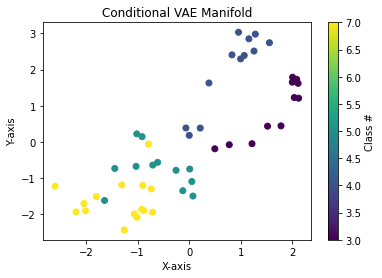

In [241]:
# plot manifold
plt.scatter(xys[:, 0], xys[:, 1], c=target, cmap='viridis', marker='o')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Conditional VAE Manifold')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Class #")

# Show the plot
plt.show()

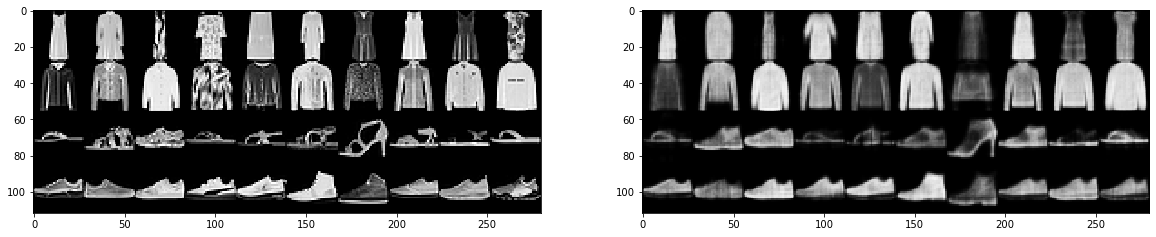

In [233]:
# generate 10 images per class (dress, coat, sandal, sneaker)

def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()

data_big, target_big = next(iter(test_loader))

data = torch.empty(0,1,28,28)
target = torch.empty(0)

for label in ["Dress", "Coat", "Sandal", "Sneaker"]:
    # subset to label
    # pick first ten elements
    label_num = master_labels.index(label)
    inds = torch.nonzero(target_big == label_num).squeeze()[:10]
    data_sub = data_big[inds,:,:,:]
    target_sub = target_big[inds]
    
    # stack on tensor
    data = torch.cat((data, data_sub))
    target = torch.cat((target, target_sub))

data_size = data.size()
data = data.view(data.size(0),-1)
target_onehot = torch.zeros(data.shape[0], 10)
target_onehot[range(data.shape[0]), target.long()] = 1
data_adj = torch.cat((data, target_onehot), dim=1)

data_adj = data_adj.to(device)

output, _, _ = best_cvae(data_adj)
output = output.detach()

show(make_grid(data.reshape(data_size), padding=0, nrow=10), make_grid(output.reshape(data_size), padding=0, nrow=10))

# Problem 2.2

In [179]:
# define model architecture

class UnconditioNet(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super(UnconditioNet, self).__init__()

        self.enc1 = nn.Linear(n_in, n_hid)
        self.enc2m = nn.Linear(n_hid, z_dim)
        self.enc2s = nn.Linear(n_hid, z_dim)
        self.dec1 = nn.Linear(z_dim, n_hid)
        self.dec2 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        h1 = F.relu(self.enc1(x))
        return self.enc2m(h1), self.enc2s(h1)

    def reparameterize(self, mu, logvar):        
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev

    def decode(self, z):
        h3 = F.relu(self.dec1(z))
        return torch.sigmoid(self.dec2(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [180]:
# define training/testing functions

def train_VAE(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0),-1)
        data = data.to(device)
        
        optimizer.zero_grad()
        output, mu, logvar = model(data)
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return train_loss

def test_VAE(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0),-1)            
            data = data.to(device)
            
            output, mu, logvar = model(data)
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}'.format(
        epoch, test_loss))
    return test_loss

In [182]:
# set up model training

optimizer_name = 'Adam'
train_num_epochs = 10
n_in = 28*28

# load best hyperparameters from cVAE
hyperparams = torch.load("hyperparameters.pth")
best_ind = torch.argmin(hyperparams[:,3])
n_hid, z_dim, lr_init = [int(elem) for elem in hyperparams[best_ind, :3]]
lr = 10**lr_init

# define model
vae = UnconditioNet(n_in, n_hid, z_dim).to(device)
optimizer = make_optimizer(optimizer_name, vae, lr=lr)

# train model
if not os.path.exists("best_VAE_weights.pth"):
    vae.train()
    for epoch in range(1, train_num_epochs + 1):
        train_VAE(vae, device, train_loader, optimizer, epoch)
    torch.save(vae.state_dict(), "best_VAE_weights.pth")
else:
    vae = UnconditioNet(int(n_in), int(n_hid_best), int(z_dim_best))
    vae.load_state_dict(torch.load("best_VAE_weights.pth"))

# test model
test_VAE(vae, device, test_loader, epoch)

Train(1)[0%]: Loss: 70462.5234
Train(1)[50%]: Loss: 39079.2938
Train(1)[100%]: Loss: 36685.3317
Train(2)[0%]: Loss: 33409.1875
Train(2)[50%]: Loss: 33190.3864
Train(2)[100%]: Loss: 32970.8460
Train(3)[0%]: Loss: 32344.4297
Train(3)[50%]: Loss: 32347.6265
Train(3)[100%]: Loss: 32188.3758
Train(4)[0%]: Loss: 31282.3691
Train(4)[50%]: Loss: 31885.5240
Train(4)[100%]: Loss: 31787.3562
Train(5)[0%]: Loss: 31286.6758
Train(5)[50%]: Loss: 31577.1630
Train(5)[100%]: Loss: 31546.4689
Train(6)[0%]: Loss: 31323.7559
Train(6)[50%]: Loss: 31412.9422
Train(6)[100%]: Loss: 31377.9458
Train(7)[0%]: Loss: 30531.8203
Train(7)[50%]: Loss: 31286.3584
Train(7)[100%]: Loss: 31269.9615
Train(8)[0%]: Loss: 31965.9844
Train(8)[50%]: Loss: 31170.0682
Train(8)[100%]: Loss: 31175.4792
Train(9)[0%]: Loss: 31353.0176
Train(9)[50%]: Loss: 31173.5927
Train(9)[100%]: Loss: 31100.7907
Train(10)[0%]: Loss: 31239.4883
Train(10)[50%]: Loss: 31049.2272
Train(10)[100%]: Loss: 31036.9186
Test(10): Loss: 31224.8554


31224.85535

In [242]:
# set up encoded dataset

# Labels for later
master_labels = ["T-shirt", "Pants", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Load the FashionMNIST dataset
dataset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# set up data loader
# extract data
_, (data_big, target_big) = next(enumerate(test_loader))

data = torch.empty(0,1,28,28)
target = torch.empty(0)

for label in ["Dress", "Coat", "Sandal", "Sneaker"]:
    # subset to label
    # pick first ten elements
    label_num = master_labels.index(label)
    inds = torch.nonzero(target_big == label_num).squeeze()[:64]
    data_sub = data_big[inds,:,:,:]
    target_sub = target_big[inds]
    
    # stack on tensor
    data = torch.cat((data, data_sub))
    target = torch.cat((target, target_sub))
    
# encode to latent representations
data = data.view(data.size(0),-1)
data_adj = data
data_enc, _, _ = vae(data_adj)

# convert latent space to 2-D representation
xys_vae = tsne(data_enc.detach().numpy(), initial_dims=784)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 50...
Mean value of sigma: 6.354944
Iteration 10: error is 10.027535
Iteration 20: error is 10.160423
Iteration 30: error is 9.962111
Iteration 40: error is 11.193229
Iteration 50: error is 10.240972
Iteration 60: error is 11.062531
Iteration 70: error is 9.978937
Iteration 80: error is 10.732067
Iteration 90: error is 11.169940
Iteration 100: error is 10.373302
Iteration 110: error is 1.092721
Iteration 120: error is 0.927085
Iteration 130: error is 0.866500
Iteration 140: error is 0.794036
Iteration 150: error is 0.694102
Iteration 160: error is 0.626317
Iteration 170: error is 0.569957
Iteration 180: error is 0.530376
Iteration 190: error is 0.503395
Iteration 200: error is 0.456229
Iteration 210: error is 0.398342
Iteration 220: error is 0.330634
Iteration 230: error is 0.320761
Iteration 240: error is 0.299345
Iteration 250: error is 0.274778
Iteration 260: error is 0.256822
Itera

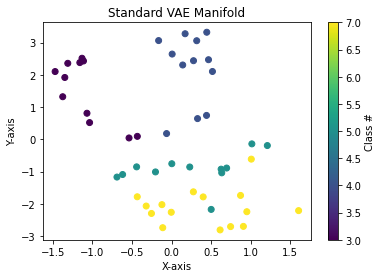

In [243]:
# plot manifold
plt.scatter(xys_vae[:, 0], xys_vae[:, 1], c=target, cmap='viridis', marker='o')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Standard VAE Manifold')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Class #")

# Show the plot
plt.show()

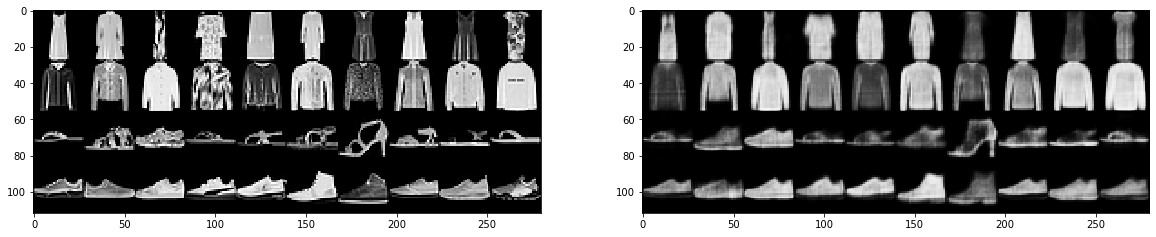

In [235]:
# generate 10 images per class (dress, coat, sandal, sneaker)

def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()

data_big, target_big = next(iter(test_loader))

data = torch.empty(0,1,28,28)
target = torch.empty(0)

for label in ["Dress", "Coat", "Sandal", "Sneaker"]:
    # subset to label
    # pick first ten elements
    label_num = master_labels.index(label)
    inds = torch.nonzero(target_big == label_num).squeeze()[:10]
    data_sub = data_big[inds,:,:,:]
    target_sub = target_big[inds]
    
    # stack on tensor
    data = torch.cat((data, data_sub))
    target = torch.cat((target, target_sub))

data_size = data.size()
data = data.view(data.size(0),-1)
data_adj = data

data_adj = data_adj.to(device)

output, _, _ = vae(data_adj)
output = output.detach()

show(make_grid(data.reshape(data_size), padding=0, nrow=10), make_grid(output.reshape(data_size), padding=0, nrow=10))

**Interpretation**: Comparing the two VAEs, the manifold in the conditional variant is noticeably more continuous than in the standard version. There is also more mixing between members of different classes, indicating we can get smoother transformations between them.